# CXR14 EDA

This is an exploratory data analysis of the Chest X-ray CXR-14 dataset from the NIHCC.

## Table of Contents
_"You can observe a lot by just watching." ~Yogi Berra_

1. [Setup and load data](#1.-Setup)
2. [Data cleaning](#2.-Data-cleaning)
3. [Begin EDA](#3.-Begin-EDA)
4. Data Transformations
    - One-hot encoding for Finding Labels
    - Total sum of Finding Labels per x-ray 
    - Combined width-by-height combinations and counts
5. X-ray image size and resolution
5. Finding Labels (target variable for modeling)
    - Distributions of 14 thoracic disease classes
    - Normal vs. non-normal
    - Co-morbidities for multi-label X-rays (pie chart [example])
6. Patient Age, Gender, and X-ray follow-up #
7. *To Do:* X-ray image examples and augmentation
8. (optional) *To Do:* Binary logistic regression for likelihood of non-normal based on Age, Gender, and Follow-up #


## 1. Setup

### Load Python packages used for analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing the data
import seaborn as sns # prettier visuals of data, built on matplotlib
from collections import OrderedDict # to preserve column order when creating DFs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker # for customizing axis tick marks in plots

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
# Uncomment to check pandas environment
# pd.show_versions() # show versions of pandas and all of its dependencies
# pd.__version__ # show pandas version only

### Load data
Source: NIH  
File: Data_Entry_2017.csv  
Repo: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345  

In [4]:
xrayDataIn = pd.read_csv('../data/Data_Entry_2017.csv')

In [5]:
xrayDataIn.shape

(112120, 12)

**How many rows and columns are the data?**

The original X-ray data file provides 112,120 rows and 12 columns.

In [6]:
xrayDataIn.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


**What does each row of data represent?**

Each row is a single X-ray, each with the following information:

- Image Index - unique image PNG filename for each X-ray
- Finding Labels - pipe-separated list of pathologies detected in X-ray, or "No Finding" if none
- Follow-up # - zero for first X-ray per patient, and incremented by one for subsequent X-rays
- Patient Age - age, in years
- Patient ID
- Patient Gender - Category with two classes:
    - F for Female
    - M for Male
- View Position - Category with two classes:
    - PA for posterioranterior position
    - AP for anteroposterior position
- OriginalImage\[Width - image width, in pixels
- Height\] - image height, in pixels
- OriginalImagePixelSpacing\[x - horizontal image pixel spacing
- y\] - vertical image pixel spacing
- Unnamed: 11 - junk

In [7]:
# list each column by name, non-null counts, and data type
xrayDataIn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
Image Index                    112120 non-null object
Finding Labels                 112120 non-null object
Follow-up #                    112120 non-null int64
Patient ID                     112120 non-null int64
Patient Age                    112120 non-null int64
Patient Gender                 112120 non-null object
View Position                  112120 non-null object
OriginalImage[Width            112120 non-null int64
Height]                        112120 non-null int64
OriginalImagePixelSpacing[x    112120 non-null float64
y]                             112120 non-null float64
Unnamed: 11                    0 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


Observations:
- Total of 112,120 rows, one per X-ray
- No missing data, with exception of empty column 'Unnamed: 11'
- Categories 'Patient Gender' and 'View Position' imported with type *object*; change to type *category*

## 2. Data cleaning

- Copy X-ray data set and drop unused column
- Clean up data types and column names
- Parse "Finding Labels" into separate columns for each pathology
- Create column to show sum of total pathologies found for each X-ray
- Create column with binary flag if Non-normal X-ray
- Create column with Age Groups for summarization

In [8]:
# copy dataframe and drop unused column
xrays = xrayDataIn.drop('Unnamed: 11', axis=1)

In [9]:
# change data type to category
for col in ['Patient Gender','View Position']:
    xrays[col] = xrays[col].astype('category')

# simplify column names
xrays.rename(columns = {'OriginalImage[Width':'ImgWidth'}, inplace = True)
xrays.rename(columns = {'Height]':'ImgHeight'}, inplace = True)
xrays.rename(columns = {'OriginalImagePixelSpacing[x':'ImgPxSpaceX'}, inplace = True)
xrays.rename(columns = {'y]':'ImgPxSpaceY'}, inplace = True)

In [10]:
# create new column for each disease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis',
                  'Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

# for each pathology, for each row, set to 1 if label is found, or 0 if not found
for pathology in pathology_list :
    xrays.loc[:, pathology] = xrays['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

# Code block credited to Stephane Bernadec's Kaggle kernel.

In [11]:
# create column for total number of pathologies in each X-ray; axis=1 to sum by columns
xrays.loc[:, 'TotalPathos'] = xrays.iloc[:, 11:26].sum(axis=1)

# create column with binary flag if Non-normal X-ray
xrays.loc[:, 'Non-normal'] = xrays['TotalPathos'].apply(lambda x: 1 if (x > 0) else 0)

# create column with combined image width by height string
xrays.loc[: ,"ImageWxH"] = xrays["ImgWidth"].map(str) + "x" + xrays["ImgHeight"].map(str)

In [12]:
# create column with age groups
def age_groups(series):
    if series < 18:
        return "1-18 yrs"
    elif 18 <= series < 25:
        return "18-24 yrs"
    elif 25 <= series < 35:
        return "25-34 yrs"
    elif 35 <= series < 45:
        return "35-44 yrs"
    elif 45 <= series < 55:
        return "45-54 yrs"
    elif 55 <= series < 65:
        return "55-64 yrs"
    elif 65 <= series < 75:
        return "65-74 yrs"
    elif 75 <= series < 85:
        return "75-84 yrs"
    elif 85 <= series < 95:
        return "85-94 yrs"
    elif 95 <= series:
        return "95+ yrs"

xrays['Age Group'] = xrays['Patient Age'].apply(age_groups)

In [13]:
xrays.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH,Age Group
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,1,1,2682x2749,55-64 yrs
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,2,1,2894x2729,55-64 yrs
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,2,1,2500x2048,55-64 yrs
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,2500x2048,75-84 yrs
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,1,1,2582x2991,75-84 yrs


### Save cleaned data to CSV

In [14]:
# save cleaned dataframe to CSV, ignoring the index
xrays.to_csv('../data/xrays-eda-clean.csv', index=False)

### Read cleaned data from CSV

In [15]:
xrays = pd.read_csv('../data/xrays-eda-clean.csv')

In [16]:
# show index number for each column
# pd.DataFrame({'cols':xrays.columns.tolist()})

In [17]:
xrays.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH,Age Group
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,1,1,2682x2749,55-64 yrs
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,2,1,2894x2729,55-64 yrs
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,2,1,2500x2048,55-64 yrs
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,2500x2048,75-84 yrs
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,1,1,2582x2991,75-84 yrs


In [18]:
xrays.columns.tolist()

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'ImgWidth',
 'ImgHeight',
 'ImgPxSpaceX',
 'ImgPxSpaceY',
 'Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Nodule',
 'Pneumothorax',
 'Atelectasis',
 'Pleural_Thickening',
 'Mass',
 'Edema',
 'Consolidation',
 'Infiltration',
 'Fibrosis',
 'Pneumonia',
 'TotalPathos',
 'Non-normal',
 'ImageWxH',
 'Age Group']

In [19]:
# inspect column data types and look for null values
xrays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 29 columns):
Image Index           112120 non-null object
Finding Labels        112120 non-null object
Follow-up #           112120 non-null int64
Patient ID            112120 non-null int64
Patient Age           112120 non-null int64
Patient Gender        112120 non-null object
View Position         112120 non-null object
ImgWidth              112120 non-null int64
ImgHeight             112120 non-null int64
ImgPxSpaceX           112120 non-null float64
ImgPxSpaceY           112120 non-null float64
Cardiomegaly          112120 non-null int64
Emphysema             112120 non-null int64
Effusion              112120 non-null int64
Hernia                112120 non-null int64
Nodule                112120 non-null int64
Pneumothorax          112120 non-null int64
Atelectasis           112120 non-null int64
Pleural_Thickening    112120 non-null int64
Mass                  112120 non-null int64
E

## 3. Begin EDA

### Check basic stats for numeric variables

In [20]:
# show basic stats for any numeric columns
xrays.describe()

,Follow-up #,Patient ID,Patient Age,ImgWidth,ImgHeight,ImgPxSpaceX,ImgPxSpaceY,Cardiomegaly,Emphysema,Effusion,...,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,0.024759,0.022440,0.118775,...,0.103095,0.030191,0.051570,0.020540,0.041625,0.177435,0.015037,0.012763,0.724010,0.461639
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,0.155391,0.148111,0.323524,...,0.304084,0.171113,0.221158,0.141841,0.199732,0.382038,0.121702,0.112251,0.963195,0.498529
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000


**How many x-rays are there? How many are normal vs. non-normal?**

In [21]:
n = xrays[xrays['Finding Labels']=='No Finding']['Image Index'].count()
nn = xrays.shape[0] - n
print("Total X-rays: \t{:,}".format(n + nn))
print("- Normal: \t {:,}".format(n))
print("- Non-normal: \t {:,}".format(nn))

Total X-rays: 	112,120
- Normal: 	 60,361
- Non-normal: 	 51,759


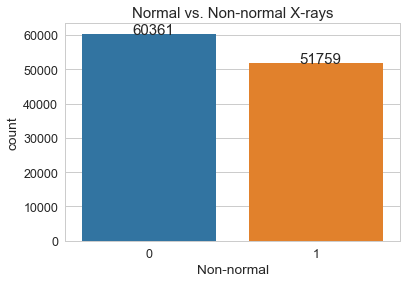

In [22]:
# increase font label size
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

# Plot normal v. non-normal X-ray counts
x = xrays['Non-normal']
ax = sns.countplot(x);

# label bars with counts
for p, label in zip(ax.patches, x.value_counts()):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.5))

plt.title('Normal vs. Non-normal X-rays')

# save PNG
plt.savefig('charts/countplot_normal_nonnormal.png', bbox_inches='tight')

**How many patients are there?**

In [23]:
# Count unique 'Patient ID'
p = xrays['Patient ID'].nunique()
print("Total Patients: {:,}".format(p))

puniqnonnorm = xrays[xrays['Non-normal'] == 1]['Patient ID'].nunique()
print("- Patients with Non-normal X-rays: {:,}".format(puniqnonnorm))

puniqnorm = xrays[xrays['Non-normal'] == 0]['Patient ID'].nunique()
print("- Patients with Normal X-rays: {:,}".format(puniqnorm))

Total Patients: 30,805
- Patients with Non-normal X-rays: 14,402
- Patients with Normal X-rays: 24,907


Observation: Many patients who have multiple X-rays must have both normal and non-normal results.

**How many of the patients with multiple X-rays have both normal and non-normal findings among those X-rays?**

In [24]:
# def fun_pcheck(p, df):
#     '''Returns True if patient has both normal and non-normal X-rays'''
#     patient = df[df['Patient ID'] == p]    
#     if (len(patient['Non-normal'].unique()) == 1):
#         return False # X-rays are all normal or all non-normal
#     return True # X-rays have mixed results

# IDs of patients with multiple X-rays
# pids_multi = xrays[xrays['Follow-up #'] > 0]['Patient ID'].unique()

# subset columns
# cols = ['Patient ID','Non-normal']
# sub1 = xrays[cols]

# count of patients with combo results (norm/non)
# pboth = 0
# for p in pids_multi:    
#     if (fun_pcheck(p, sub1) == True):
#        pboth += 1

# print('There are {:,} patients with more than one X-ray.'.format(len(pids_multi)))
# print('Of these patients, {:,} have both normal and non-normal X-rays.'.format(pboth))

There are 13,302 patients with more than one X-ray.  
Of these patients, 8,504 have both normal and non-normal X-rays.

In [25]:
xrays['Age Group'].value_counts(sort=False)

1-18 yrs      5241
35-44 yrs    17704
25-34 yrs    15120
95+ yrs         17
18-24 yrs     7651
65-74 yrs    12736
75-84 yrs     2993
55-64 yrs    25220
45-54 yrs    25114
85-94 yrs      324
Name: Age Group, dtype: int64

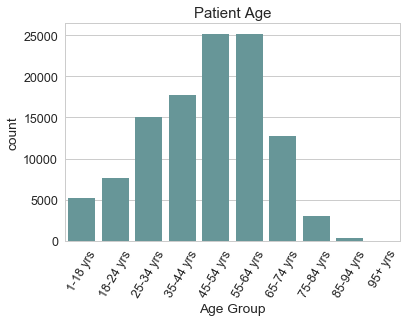

In [26]:
df = xrays[['Age Group']].sort_values(by=['Age Group'])
g = sns.countplot(df['Age Group'], color='cadetblue');
plt.setp(g.get_xticklabels(), rotation=60);
plt.title('Patient Age');

# save chart as PNG
plt.savefig('charts/age_groups.png', bbox_inches='tight');

**As of the first x-ray, what are patients' ages?**

In [27]:
# first X-ray
xr1 = xrays[xrays['Follow-up #'] == 0]
print("The plot below represents all {:,} patients.".format(xr1.shape[0]))

The plot below represents all 30,805 patients.


A benefit of only looking at the first X-ray is that each patient is counted once, as opposed to once per X-ray.

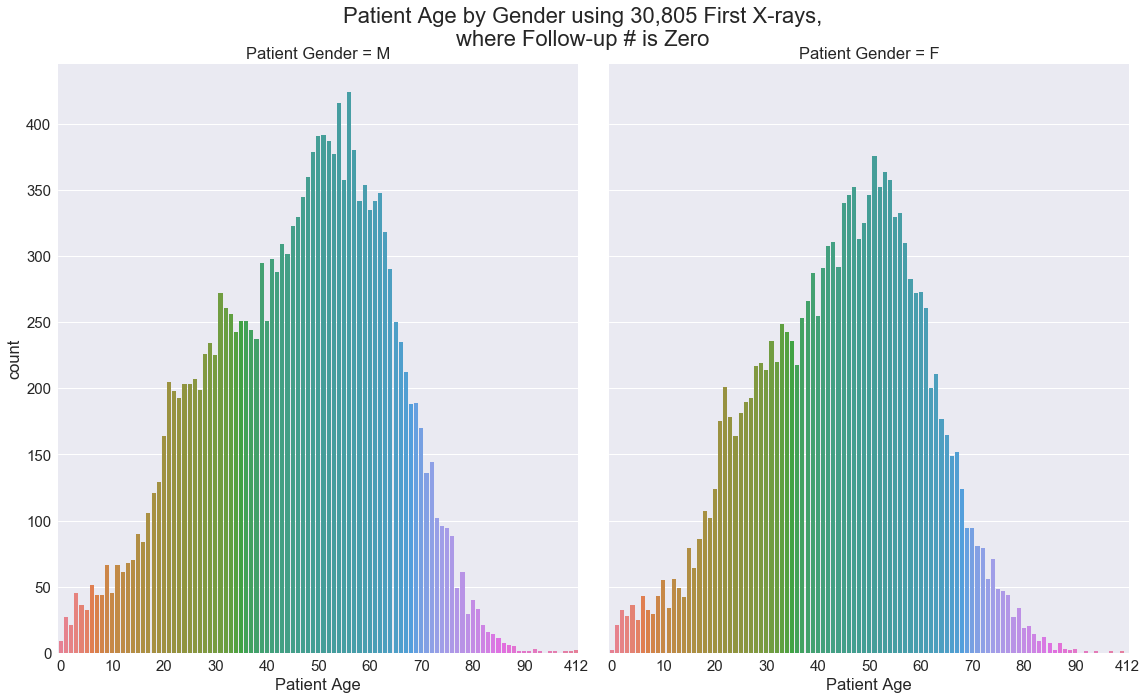

In [28]:
# Enlarge the plot
plt.figure(figsize=(3.5,3));

# plot code adapted from sbernadac (Kaggle) to address the "first X-ray" question
sns.set(font_scale = 1.5);
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=xr1, kind="count",size=10, aspect=0.8,palette="husl");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Patient Age by Gender using 30,805 First X-rays,\nwhere Follow-up # is Zero',fontsize=22);
g.fig.subplots_adjust(top=.9);

# save chart as PNG
plt.savefig('charts/age_by_gender_first_xray.png', bbox_inches='tight');

In [29]:
# count M and F in first xray
totalmen = xr1[xr1['Patient Gender'] == 'M']['Patient ID'].nunique()
totalmenxrays = xrays[xrays['Patient Gender'] == 'M']['Image Index'].nunique()
totalwommen = xr1[xr1['Patient Gender'] == 'F']['Patient ID'].nunique()
totalwomenxrays = xrays[xrays['Patient Gender'] == 'F']['Image Index'].nunique()
print('The dataset contains:')
print( '- {:,} X-rays from {:,} men.'.format(totalmenxrays, totalmen))
print( '- {:,} X-rays from {:,} wommen.'.format(totalwomenxrays, totalwommen))

The dataset contains:
- 63,340 X-rays from 16,630 men.
- 48,780 X-rays from 14,175 wommen.


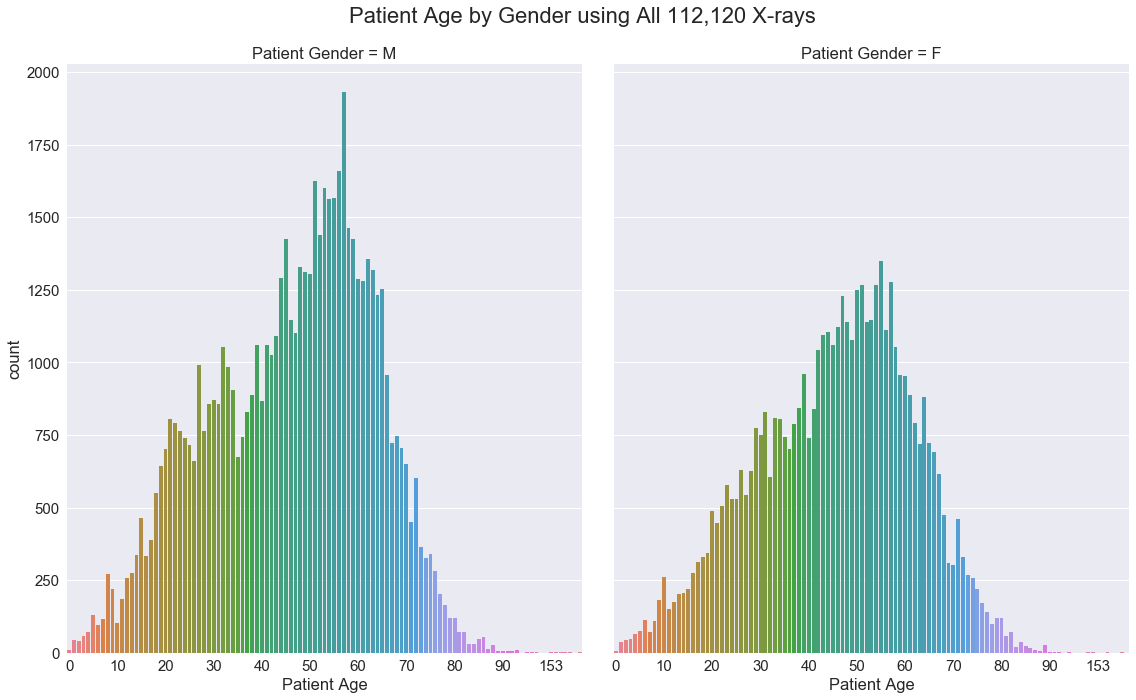

In [30]:
# plot code adapted from sbernadac (Kaggle)
sns.set(font_scale = 1.5)
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=xrays, kind="count",size=10, aspect=0.8,palette="husl");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Patient Age by Gender using All 112,120 X-rays',fontsize=22);
g.fig.subplots_adjust(top=.9)

# save chart as PNG
plt.savefig('charts/age_by_gender_all_xrays.png', bbox_inches='tight')

## Correlations

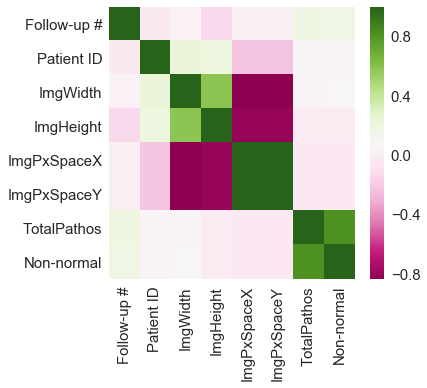

In [31]:
# Enlarge the plot
plt.figure(figsize=(5.5,5))

# Calculate correlations
corr = xrays.iloc[:, [2,3,7,8,9,10,25,26]].corr()

# Heatmap
sns.heatmap(corr, cmap='PiYG');

# save PNG
plt.savefig('charts/corr_img_oddends.png', bbox_inches='tight')

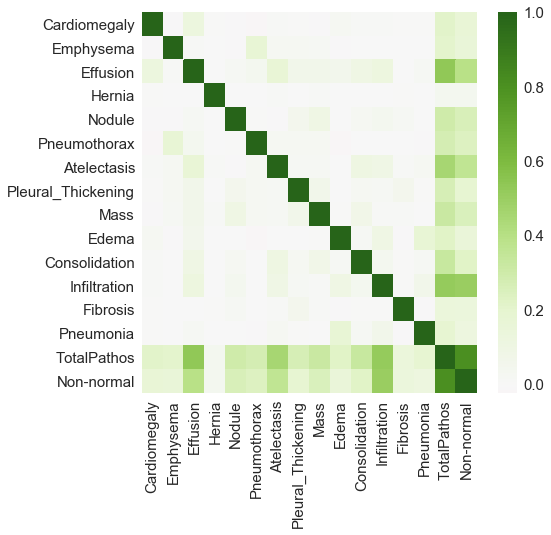

In [32]:
# Enlarge the plot
plt.figure(figsize=(7.5,7))

# Calculate correlations
corr = xrays.iloc[:, 11:27].corr()

# Heatmap
sns.heatmap(corr, cmap='PiYG', center=0);

# save PNG
plt.savefig('charts/corr_diseases.png', bbox_inches='tight')

Insights from correlation plots:
- Total pathologies are most positively correlated with Effusion, Atelectasis, and Infiltration
- Total pathologies are least correlated with Hernia
- Image Width and Height are *negatively* correlated with Image Pixel Spacing

**Is there any correlation between Age and Follow-up #?**

In [33]:
# Avg. Patient Age as of the 11th X-ray
xrays[xrays['Follow-up #'] == 10]['Patient Age'].mean(axis=0)

47.73438202247191

In [34]:
# Compute average age of patients at each X-ray Follow-up #
maxfu = xrays['Follow-up #'].max(axis=0) # 183
fu = []   # follow-up number
favage = [] # avg. age
for f in range(maxfu):
    a = xrays[xrays['Follow-up #'] == f]['Patient Age'].mean(axis=0)
    fu.append(f)
    favage.append(a)

df_fufav = pd.DataFrame({'Follow-up #':fu, 'Average Age':favage})

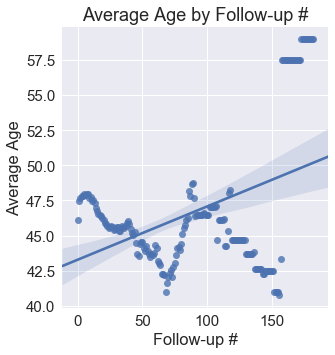

In [35]:
# Plot Average Age by Follow-up #
g = sns.lmplot(x='Follow-up #', y='Average Age', data=df_fufav);
plt.title('Average Age by Follow-up #');

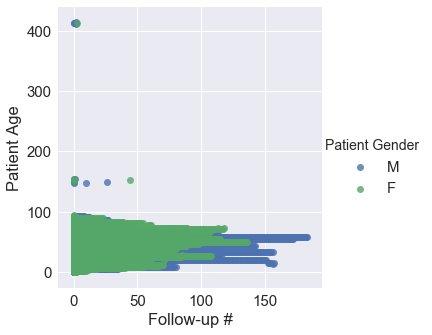

In [36]:
# plot with simple linear regression
sns.lmplot(x='Follow-up #', y='Patient Age', data=xrays,
           fit_reg=False, # No regression line
           hue='Patient Gender');

Observations:
* Follow-up # ranges from low of 0 (first visit) to high of 183 with a median of 3
* Patient Age ranges from 1 to 414; need to investigate extreme values
* 

Next, explore the variety of image widths, heights, and pixel spacing.

In [37]:
# List categories and counts
for cat in ['Patient Gender', 'View Position']:
    print( "{}\n".format(xrays[cat].value_counts()) )

M    63340
F    48780
Name: Patient Gender, dtype: int64

PA    67310
AP    44810
Name: View Position, dtype: int64



### X-ray image size and dimensions

In [38]:
w = len(xrays["ImgWidth"].value_counts())
h = len(xrays["ImgHeight"].value_counts())
print("Unique image widths: {}\nUnique image heights: {}".format(w, h))

Unique image widths: 904
Unique image heights: 1137


In [39]:
# create column with combined image width by height string
xrays.loc[: ,"ImageWxH"] = xrays["ImgWidth"].map(str) + "x" + xrays["ImgHeight"].map(str)

In [40]:
xrays["ImageWxH"].head()

0    2682x2749
1    2894x2729
2    2500x2048
3    2500x2048
4    2582x2991
Name: ImageWxH, dtype: object

In [41]:
# summarize unique combinations of image dimensions
wh = len(xrays["ImageWxH"].value_counts())
print("Number of unique image dimensions (WxH) among chest X-rays: {}".format(wh))

Number of unique image dimensions (WxH) among chest X-rays: 10471


In [42]:
xrays["ImgWidth"].sort_values().tail()

89043     3343
103299    3416
107811    3451
109176    3550
106673    3827
Name: ImgWidth, dtype: int64

### X-ray Image Resolution in Megapixels

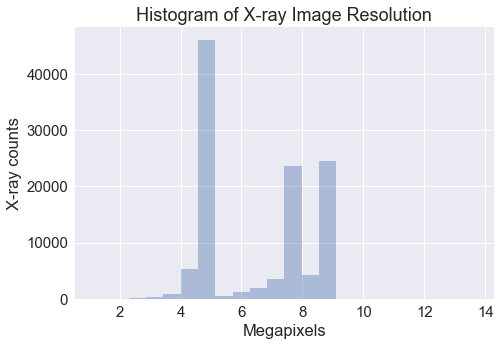

In [43]:
# Enlarge the plot
plt.figure(figsize=(7.5,5))

# histogram of image W x H
sns.distplot(xrays["ImgWidth"]*xrays["ImgHeight"]/1000000, bins=22,  kde=False);
plt.title('Histogram of X-ray Image Resolution');
plt.xlabel('Megapixels');
plt.ylabel('X-ray counts');

# save PNG
plt.savefig('charts/hist_total_pixels.png', bbox_inches='tight')

In [44]:
# most common image dimensions
xrays["ImageWxH"].value_counts().head(10)

2500x2048    37153
2992x2991    21961
3056x2544    15340
2048x2500     8683
2021x2021     4411
2544x3056     2418
2990x2991      483
2020x2021      331
2021x2020      279
2986x2991      166
Name: ImageWxH, dtype: int64

In [45]:
x = len(xrays["ImgPxSpaceX"].value_counts())
y = len(xrays["ImgPxSpaceY"].value_counts())
print("Unique x pixel spacings: {}\nUnique y pixel spacings: {}".format(x, y))

Unique x pixel spacings: 23
Unique y pixel spacings: 23


## Exploratory Questions

* What are the overall age and gender distributions?
* What are the age and gender distributions by pathology?
* Are there correlations between "Follow-up #", Age, Gender, and Pathologies?


### Age analysis

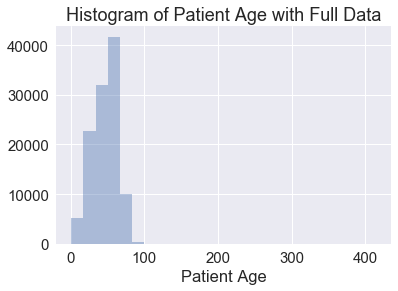

In [46]:
# histogram by Age
sns.distplot(xrays["Patient Age"], bins=25,  kde=False);
plt.title('Histogram of Patient Age with Full Data');

**What are the outliers at high end of 'Patient Age'?**

In [47]:
xrays.iloc[:, 0:6].sort_values(by='Patient Age', ascending=False).head(20)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender
46965,00011973_002.png,Edema,2,11973,414,M
86264,00021275_003.png,No Finding,3,21275,413,F
91369,00022811_000.png,No Finding,0,22811,412,M
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M
84810,00020900_002.png,No Finding,2,20900,411,M
101194,00026871_000.png,No Finding,0,26871,155,F
104590,00027989_000.png,No Finding,0,27989,155,M
98495,00026028_001.png,Atelectasis,1,26028,154,M
95794,00025206_000.png,Infiltration|Mass,0,25206,153,M


Finding: 16 X-rays list Patient Age of 148 or greater. Perhaps that value is mislabeled, or not 'years' in some instances. Look at same patient where possible.

In [48]:
# Filter by 'Patient ID' where 'Patient Age' is over 100
xrays[xrays['Patient ID'].isin(xrays[xrays['Patient Age'] > 100]['Patient ID'])].tail(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH,Age Group
91374,00022811_005.png,No Finding,5,22811,25,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,3056x2544,25-34 yrs
95794,00025206_000.png,Infiltration|Mass,0,25206,153,M,PA,2992,2991,0.143,...,1,0,0,1,0,0,2,1,2992x2991,95+ yrs
95795,00025206_001.png,Mass|Nodule,1,25206,36,M,PA,2992,2991,0.143,...,1,0,0,0,0,0,2,1,2992x2991,35-44 yrs
95796,00025206_002.png,Nodule,2,25206,36,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,1,2992x2991,35-44 yrs
95797,00025206_003.png,Mass|Nodule,3,25206,36,M,AP,3056,2544,0.139,...,1,0,0,0,0,0,2,1,3056x2544,35-44 yrs
95798,00025206_004.png,Nodule,4,25206,36,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,1,1,3056x2544,35-44 yrs
98494,00026028_000.png,Infiltration,0,26028,60,M,PA,3056,2544,0.139,...,0,0,0,1,0,0,1,1,3056x2544,55-64 yrs
98495,00026028_001.png,Atelectasis,1,26028,154,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,1,2992x2991,95+ yrs
101194,00026871_000.png,No Finding,0,26871,155,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,2992x2991,95+ yrs
104590,00027989_000.png,No Finding,0,27989,155,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,2992x2991,95+ yrs


Findings:
- Patient ID 25206 is Age 153 at Follow-up \#0, then Age 36 at all future Follow-ups.
- Patient ID 26028 is Age 60 at Follow-up \#0, but Age 154 at future Follow-ups.

**Age Outliers Conclusion:** A handful of 'Patient Age' outliers reveal errors in this data. In cases where an Age outlier Patient ID has matching Follow-up #'s, the Patient Age could be corrected on a case-by-case basis. This could improve EDA statistical summaries, or if Age were to be used as a data modeling input. Regardless, the rows for these X-ray images will be left in the data set.


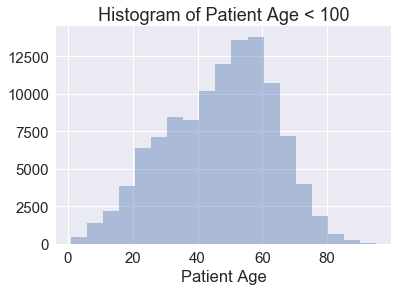

In [49]:
# histogram by Age < 100
sns.distplot(xrays[xrays["Patient Age"] < 100]["Patient Age"], bins=19,  kde=False);
plt.title('Histogram of Patient Age < 100');

### Follow-up # Analysis
**What is the range and distribution of "Follow-up #"?**

In [50]:
# quick stats on multiple series
xrays[["TotalPathos", "Follow-up #"]].describe()

,TotalPathos,Follow-up #
count,112120.000000,112120.000000
mean,0.724010,8.573751
std,0.963195,15.406320
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,3.000000
75%,1.000000,10.000000
max,9.000000,183.000000


In [51]:
# List top 20 X-ray counts by Follow-up #
a = xrays['Follow-up #']
unique_elements, counts_elements = np.unique(a, return_counts=True)

# counts_elements_proportion_of_patients
counts_elements_pop = counts_elements/counts_elements[0]
print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))
xrfu = pd.DataFrame( OrderedDict( {'Follow-up #':unique_elements, 'X-ray count':counts_elements, 'Proportion of patients':counts_elements_pop} ) )
xrfu.head(20)

Frequency of unique values of the said array:


,Follow-up #,X-ray count,Proportion of patients
0,0,30805,1.000000
1,1,13302,0.431813
2,2,9189,0.298296
3,3,7089,0.230125
4,4,5759,0.186950
5,5,4821,0.156501
6,6,4034,0.130953
7,7,3426,0.111216
8,8,2932,0.095179
9,9,2545,0.082616


In [52]:
xrfu[30:36]

,Follow-up #,X-ray count,Proportion of patients
30,30,397,0.012888
31,31,380,0.012336
32,32,358,0.011621
33,33,338,0.010972
34,34,315,0.010226
35,35,291,0.009447


**Insights based on Follow-up #:**
- More than 90% of patients have fewer than 10 X-rays
- Fewer than 1% of patients have more than 35 X-rays

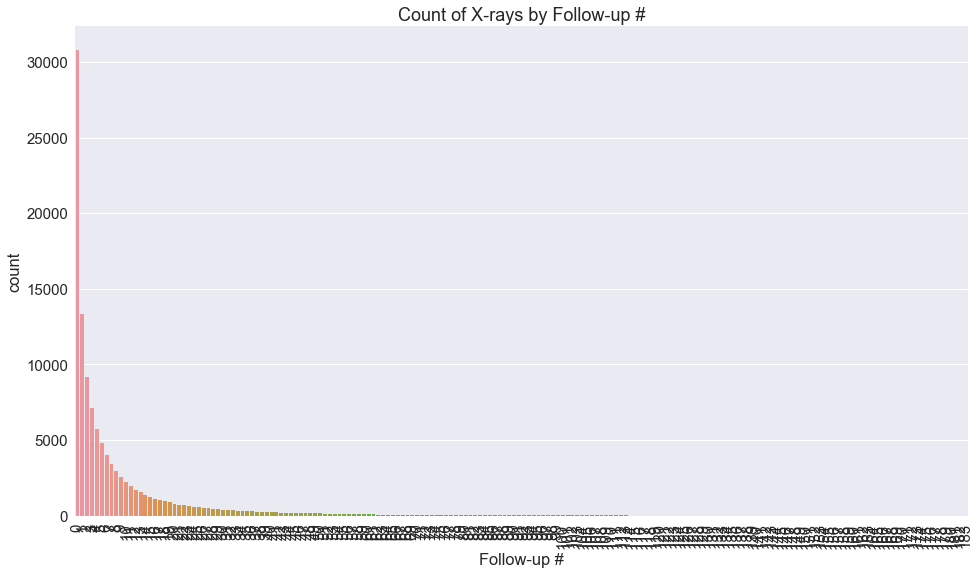

In [53]:
x = xrays['Follow-up #']
plt.figure(figsize=(16, 9))
g = sns.countplot(x);
g.set_xticklabels(np.arange(min(x), max(x)+1, step=1));
#g.set_xticklabels(step=10);
plt.setp(g.get_xticklabels(), rotation=90);
plt.title('Count of X-rays by Follow-up #');

Insights:
* A given x-ray has anywhere from 0 to 9 total pathologies.
* The "Follow-up #" ranges from 0 (first visit and x-ray) to 183.

In [54]:
%matplotlib inline

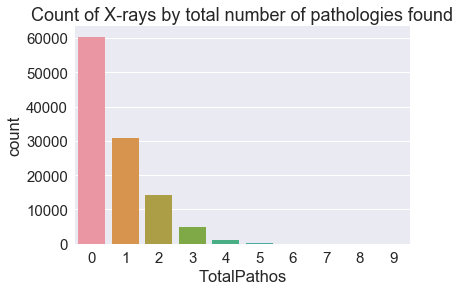

In [55]:
x = xrays['TotalPathos']
sns.countplot(x);
plt.title('Count of X-rays by total number of pathologies found');

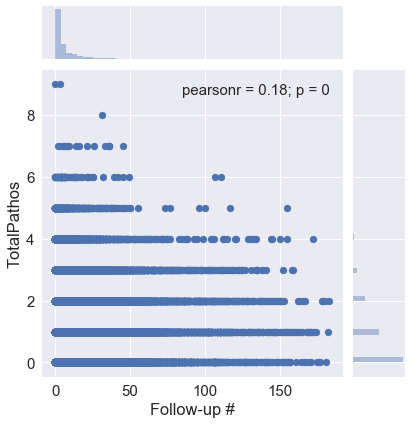

In [56]:
# Plot of "Follow-up #" with 
sns.jointplot(x="Follow-up #", y="TotalPathos", data=xrays);

### Finding Labels

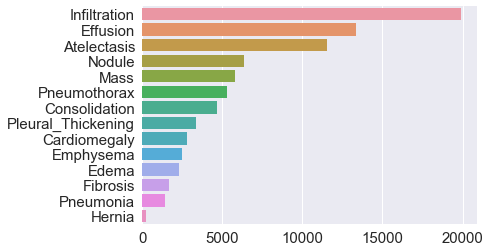

In [57]:
# pathology counts
pathos = xrays.iloc[:,11:25].sum().sort_values(ascending=False)
g = sns.barplot(x=pathos, y=pathos.index);

In [58]:
print(pathos)

Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


### Example of Single Patient X-ray History

In [59]:
xrays[xrays['Patient ID'] == 11997]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImgWidth,ImgHeight,ImgPxSpaceX,...,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,TotalPathos,Non-normal,ImageWxH,Age Group
47048,00011997_000.png,No Finding,0,11997,42,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,2500x2048,35-44 yrs
47049,00011997_001.png,No Finding,1,11997,43,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,2992x2991,35-44 yrs
47050,00011997_002.png,No Finding,2,11997,43,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,2500x2048,35-44 yrs
47051,00011997_003.png,Effusion,3,11997,43,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,1,2992x2991,35-44 yrs
47052,00011997_004.png,Cardiomegaly|Effusion|Infiltration,4,11997,44,M,PA,2698,2781,0.143,...,0,0,0,1,0,0,3,1,2698x2781,35-44 yrs
47053,00011997_005.png,No Finding,5,11997,45,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,2500x2048,45-54 yrs
47054,00011997_006.png,No Finding,6,11997,45,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,2992x2991,45-54 yrs
47055,00011997_007.png,No Finding,7,11997,45,M,PA,2992,2469,0.143,...,0,0,0,0,0,0,0,0,2992x2469,45-54 yrs
47056,00011997_008.png,Infiltration,8,11997,45,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,1,1,2992x2991,45-54 yrs
47057,00011997_009.png,No Finding,9,11997,45,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,2992x2991,45-54 yrs


# References

As noted, some charts and code wizardry used here are credited to the excellent [Lung diseases data analysis](https://www.kaggle.com/sbernadac/lung-deseases-data-analysis) by Stephane Bernadec (sbernadec) on Kaggle.